In [1]:
from esper.prelude import *
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.temporal_predicates import overlaps
from esper.rekall import *
import matplotlib.pyplot as plt
import cv2

# Load up Ground Truth

In [2]:
# Load up small ground truth test set - two easy sequences, one hard
shots_gt_qs = Shot.objects.filter(
    Q(video_id=123, labeler__name__contains='manual', max_frame__lte=16560) | # easy
    Q(video_id=172, labeler__name__contains='manual') | # hard
    Q(video_id=179, labeler__name__contains='manual') # easy
)

In [3]:
shots_gt = VideoIntervalCollection.from_django_qs(shots_gt_qs)

In [4]:
# Visualize the ground truth.
esper_widget(intrvllists_to_result(shots_gt), jupyter_keybindings=True, disable_captions=True)

VGridWidget(jsglobals={'bucket': 'esper', 'schema': [['Identity', ['id', 'name']], ['Genre', ['id', 'name']], …

# Evaluate Baselines

## Load up Shots from Heuristics

In [5]:
# Figure out temporal extents of the clips that were labeled
clips = shots_gt.dilate(1).coalesce().dilate(-1)

In [6]:
cinematic_shots_qs = Shot.objects.filter(cinematic=True).all()
cinematic_shots = VideoIntervalCollection.from_django_qs(
    cinematic_shots_qs,
    progress = True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875669/875669 [00:02<00:00, 303018.57it/s]


In [7]:
cinematic_shots = cinematic_shots.filter_against(
    clips,
    predicate=overlaps()
)

In [8]:
cinematic_shot_boundaries = cinematic_shots.map(lambda i: (i.start, i.start, i.payload))
gt_shot_boundaries = shots_gt.map(lambda i: (i.start, i.start, i.payload))

In [9]:
def size(interval_collection):
    count = 0
    for video_id in interval_collection.get_allintervals():
        count += interval_collection.get_intervallist(video_id).size()
        
    return count

In [10]:
def print_per_video_precision_recall(gt_shot_boundaries, eval_shot_boundaries):
    for video_id in gt_shot_boundaries.get_allintervals():
        print("Video {}: ".format(video_id))
        cine_sb = VideoIntervalCollection({
            video_id: cinematic_shot_boundaries.get_intervallist(video_id)
        })
        gt_sb = VideoIntervalCollection({
            video_id: gt_shot_boundaries.get_intervallist(video_id)
        })
        accurate_sb = cine_sb.filter_against(gt_sb, predicate=overlaps())
        inaccurate_sb = cine_sb.minus(accurate_sb)

        found_human_sb = gt_sb.filter_against(cine_sb, predicate=overlaps())
        missed_human_sb = gt_sb.minus(found_human_sb)
        
        print("Precision: {}, {} out of {}".format(
            size(accurate_sb) / size(cine_sb), 
            size(accurate_sb), 
            size(cine_sb)))
        print("Recall: {}, {} out of {}".format(
            size(accurate_sb) / size(gt_sb), 
            size(accurate_sb), 
            size(gt_sb)))

In [11]:
print_per_video_precision_recall(gt_shot_boundaries, cinematic_shot_boundaries)

Video 123: 
Precision: 1.0, 17 out of 17
Recall: 1.0, 17 out of 17
Video 172: 
Precision: 0.7222222222222222, 13 out of 18
Recall: 0.52, 13 out of 25
Video 179: 
Precision: 1.0, 14 out of 14
Recall: 0.875, 14 out of 16


In [12]:
# Visualize the discrepancies. Ground truth is in red, heuristic results are in blue.
result = intrvllists_to_result(shots_gt, color='red')
add_intrvllists_to_result(result, cinematic_shots, color='blue')
esper_widget(result, jupyter_keybindings=True, disable_captions=True)

VGridWidget(jsglobals={'bucket': 'esper', 'schema': [['Identity', ['id', 'name']], ['Genre', ['id', 'name']], …

## Machine Learning

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import time
import datetime
from tqdm import tqdm
import copy
import scannertools as st

In [5]:
st.init_storage(os.environ['BUCKET'])

In [6]:
class VideoNet(nn.Module):
    def __init__(self):
        super(VideoNet, self).__init__()
        self.resnet1 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
        self.resnet2 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
        self.resnet3 = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)
        
        # Replace pooling layer with Adaptive Pooling
        self.resnet1.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet2.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet3.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.embeddingconv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        nn.init.kaiming_normal_(self.embeddingconv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, image1, image2, image3):
        image1embedding = self.resnet1(image1).unsqueeze(1)
        image2embedding = self.resnet2(image2).unsqueeze(1)
        image3embedding = self.resnet3(image3).unsqueeze(1)
        
#         print(image1embedding.size())
        
        embedding_image = torch.cat(
            (image1embedding, image2embedding, image3embedding),
            dim=1
        )
        
#         print(embedding_image.size())
        
        embedding_image = embedding_image.unsqueeze(1)
        
#         print(embedding_image.size())
        out = self.embeddingconv(embedding_image)
#         print(out.size())
        out = self.relu(out)
#         print(out.size())
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.softmax(out, dim=1)
        # out = self.sigmoid(out)
        
        return out

In [7]:
class ShotDetectionDataset(Dataset):
    def __init__(self, shots, window_size=1, height=224):
        """Constrcutor for ShotDetectionDataset.
        
        Args:
            shots: VideoIntervalCollection of all the intervals to get frames from.
        """
        self.window_size = window_size
        items = set()
        frame_nums = {}
        
        for video_id in shots.get_allintervals():
            frame_nums[video_id] = set()
            for intrvl in shots.get_intervallist(video_id).get_intervals():
                for f in range(intrvl.start, intrvl.end + 1):
                    items.add((video_id, f, 1 if f == intrvl.start else 0))
                    for i in range(intrvl.start - window_size, intrvl.end + window_size + 1):
                        frame_nums[video_id].add(i)
        self.items = sorted(list(items))
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Load frames into memory
        self.frames = {
            video_id: {
                'frame_nums': sorted(list(frame_nums[video_id])),
                'frames': [
                    self.transform(f)
                    for f in Video.objects.get(id=video_id).for_scannertools().frames(
                        sorted(list(frame_nums[video_id]))
                    )
                ]
            }
            for video_id in frame_nums
        }
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        """
        Indexed by video ID, then frame number
        Returns self.window_size frames before the indexed frame to self.window_size
            frames after the indexed frame
        """
        video_id, frame_num, label = self.items[idx]
        
        start_index = self.frames[video_id]['frame_nums'].index(frame_num - self.window_size)
        img_tensors = self.frames[video_id]['frames'][start_index:start_index + 2*self.window_size + 1]
        
        return img_tensors, label

In [8]:
dataset = ShotDetectionDataset(shots_gt)

In [20]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [10]:
vnet = VideoNet()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            true_positive = 0.
            false_positive = 0.
            true_negative = 0.
            false_negative = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
#                 print("Start loop {}".format(datetime.datetime.now()))
                inputs = [i.to(device) for i in inputs]
                labels = labels.to(device)
#                 print("Moved inputs {}".format(datetime.datetime.now()))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs[0], inputs[1], inputs[2])
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
#                 print("Finished forward prop {}".format(datetime.datetime.now()))

                # statistics
                running_loss += loss.item() * inputs[0].size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                for p, l in zip(preds, labels):
                    if p.item() == l.item():
                        if l.item() == 1:
                            true_positive += 1.
                        else:
                            true_negative += 1.
                    else:
                        if p.item() == 1:
                            false_positive += 1.
                        else:
                            false_negative += 1.
                
#                 print("End loop {}".format(datetime.datetime.now()))

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)
            if true_positive + false_positive != 0:
                precision = true_positive / (true_positive + false_positive)
            else:
                precision = 0.
            if true_positive + false_negative != 0:
                recall = true_positive / (true_positive + false_negative)
            else:
                recall = 0.

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {.4f}'.format(
                phase, epoch_loss, epoch_acc, precision, recall))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
vnet = vnet.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.SGD(vnet.parameters(), lr=0.001, momentum=0.9)

In [16]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
model = train_model(vnet, criterion, optimizer, exp_lr_scheduler, num_epochs=25)



  0%|                                                                                                                                                                                                               | 0/4774 [00:00<?, ?it/s]

Epoch 0/24
----------




  0%|                                                                                                                                                                                                     | 1/4774 [00:00<1:19:16,  1.00it/s]

  0%|                                                                                                                                                                                                     | 2/4774 [00:01<1:17:31,  1.03it/s]

  0%|                                                                                                                                                                                                     | 3/4774 [00:02<1:16:10,  1.04it/s]

  0%|▏                                                                                                                                                                                                    | 4/4774 [00:03<1:15:56,  1.05it/s]

  0%|▏                                    

  1%|█▍                                                                                                                                                                                                  | 34/4774 [00:32<1:18:37,  1.00it/s]

  1%|█▍                                                                                                                                                                                                  | 35/4774 [00:33<1:20:10,  1.02s/it]

  1%|█▍                                                                                                                                                                                                  | 36/4774 [00:34<1:20:33,  1.02s/it]

  1%|█▌                                                                                                                                                                                                  | 37/4774 [00:35<1:20:09,  1.02s/it]

  1%|█▌                                     

  1%|██▊                                                                                                                                                                                                 | 67/4774 [01:04<1:14:27,  1.05it/s]

  1%|██▊                                                                                                                                                                                                 | 68/4774 [01:05<1:14:18,  1.06it/s]

  1%|██▊                                                                                                                                                                                                 | 69/4774 [01:05<1:14:49,  1.05it/s]

  1%|██▊                                                                                                                                                                                                 | 70/4774 [01:06<1:14:15,  1.06it/s]

  1%|██▉                                    

  2%|████                                                                                                                                                                                               | 100/4774 [01:35<1:13:22,  1.06it/s]

  2%|████▏                                                                                                                                                                                              | 101/4774 [01:36<1:13:05,  1.07it/s]

  2%|████▏                                                                                                                                                                                              | 102/4774 [01:37<1:13:11,  1.06it/s]

  2%|████▏                                                                                                                                                                                              | 103/4774 [01:38<1:13:10,  1.06it/s]

  2%|████▏                                  

  3%|█████▍                                                                                                                                                                                             | 133/4774 [02:06<1:12:52,  1.06it/s]

  3%|█████▍                                                                                                                                                                                             | 134/4774 [02:07<1:12:56,  1.06it/s]

  3%|█████▌                                                                                                                                                                                             | 135/4774 [02:08<1:13:25,  1.05it/s]

  3%|█████▌                                                                                                                                                                                             | 136/4774 [02:09<1:12:32,  1.07it/s]

  3%|█████▌                                 

  3%|██████▊                                                                                                                                                                                            | 166/4774 [02:37<1:13:15,  1.05it/s]

  3%|██████▊                                                                                                                                                                                            | 167/4774 [02:38<1:12:43,  1.06it/s]

  4%|██████▊                                                                                                                                                                                            | 168/4774 [02:39<1:13:05,  1.05it/s]

  4%|██████▉                                                                                                                                                                                            | 169/4774 [02:40<1:13:27,  1.04it/s]

  4%|██████▉                                

  4%|████████▏                                                                                                                                                                                          | 199/4774 [03:09<1:12:24,  1.05it/s]

  4%|████████▏                                                                                                                                                                                          | 200/4774 [03:10<1:12:42,  1.05it/s]

  4%|████████▏                                                                                                                                                                                          | 201/4774 [03:11<1:12:41,  1.05it/s]

  4%|████████▎                                                                                                                                                                                          | 202/4774 [03:12<1:12:54,  1.05it/s]

  4%|████████▎                              

  5%|█████████▍                                                                                                                                                                                         | 232/4774 [03:40<1:11:36,  1.06it/s]

  5%|█████████▌                                                                                                                                                                                         | 233/4774 [03:41<1:11:25,  1.06it/s]

  5%|█████████▌                                                                                                                                                                                         | 234/4774 [03:42<1:11:39,  1.06it/s]

  5%|█████████▌                                                                                                                                                                                         | 235/4774 [03:43<1:11:38,  1.06it/s]

  5%|█████████▋                             

  6%|██████████▊                                                                                                                                                                                        | 265/4774 [04:11<1:10:29,  1.07it/s]

  6%|██████████▊                                                                                                                                                                                        | 266/4774 [04:12<1:10:25,  1.07it/s]

  6%|██████████▉                                                                                                                                                                                        | 267/4774 [04:13<1:10:37,  1.06it/s]

  6%|██████████▉                                                                                                                                                                                        | 268/4774 [04:14<1:10:15,  1.07it/s]

  6%|██████████▉                            

  6%|████████████▏                                                                                                                                                                                      | 298/4774 [04:42<1:09:42,  1.07it/s]

  6%|████████████▏                                                                                                                                                                                      | 299/4774 [04:43<1:09:37,  1.07it/s]

  6%|████████████▎                                                                                                                                                                                      | 300/4774 [04:44<1:09:50,  1.07it/s]

  6%|████████████▎                                                                                                                                                                                      | 301/4774 [04:45<1:09:22,  1.07it/s]

  6%|████████████▎                          

  7%|█████████████▌                                                                                                                                                                                     | 331/4774 [05:13<1:10:13,  1.05it/s]

  7%|█████████████▌                                                                                                                                                                                     | 332/4774 [05:14<1:10:33,  1.05it/s]

  7%|█████████████▌                                                                                                                                                                                     | 333/4774 [05:15<1:09:58,  1.06it/s]

  7%|█████████████▋                                                                                                                                                                                     | 334/4774 [05:16<1:09:43,  1.06it/s]

  7%|█████████████▋                         

  8%|██████████████▊                                                                                                                                                                                    | 364/4774 [05:44<1:10:52,  1.04it/s]

  8%|██████████████▉                                                                                                                                                                                    | 365/4774 [05:45<1:11:18,  1.03it/s]

  8%|██████████████▉                                                                                                                                                                                    | 366/4774 [05:46<1:11:50,  1.02it/s]

  8%|██████████████▉                                                                                                                                                                                    | 367/4774 [05:47<1:11:33,  1.03it/s]

  8%|███████████████                        

  8%|████████████████▏                                                                                                                                                                                  | 397/4774 [06:16<1:09:21,  1.05it/s]

  8%|████████████████▎                                                                                                                                                                                  | 398/4774 [06:16<1:09:13,  1.05it/s]

  8%|████████████████▎                                                                                                                                                                                  | 399/4774 [06:17<1:09:45,  1.05it/s]

  8%|████████████████▎                                                                                                                                                                                  | 400/4774 [06:18<1:09:48,  1.04it/s]

  8%|████████████████▍                      

  9%|█████████████████▌                                                                                                                                                                                 | 430/4774 [06:47<1:10:39,  1.02it/s]

  9%|█████████████████▌                                                                                                                                                                                 | 431/4774 [06:48<1:10:51,  1.02it/s]

  9%|█████████████████▋                                                                                                                                                                                 | 432/4774 [06:49<1:10:23,  1.03it/s]

  9%|█████████████████▋                                                                                                                                                                                 | 433/4774 [06:50<1:09:51,  1.04it/s]

  9%|█████████████████▋                     

 10%|██████████████████▉                                                                                                                                                                                | 463/4774 [07:19<1:08:52,  1.04it/s]

 10%|██████████████████▉                                                                                                                                                                                | 464/4774 [07:20<1:09:02,  1.04it/s]

 10%|██████████████████▉                                                                                                                                                                                | 465/4774 [07:21<1:21:59,  1.14s/it]

 10%|███████████████████                                                                                                                                                                                | 466/4774 [07:23<1:28:58,  1.24s/it]

 10%|███████████████████                    

 10%|████████████████████▎                                                                                                                                                                              | 496/4774 [07:51<1:08:08,  1.05it/s]

 10%|████████████████████▎                                                                                                                                                                              | 497/4774 [07:52<1:07:47,  1.05it/s]

 10%|████████████████████▎                                                                                                                                                                              | 498/4774 [07:53<1:08:03,  1.05it/s]

 10%|████████████████████▍                                                                                                                                                                              | 499/4774 [07:54<1:07:44,  1.05it/s]

 10%|████████████████████▍                  

 11%|█████████████████████▌                                                                                                                                                                             | 529/4774 [08:23<1:08:04,  1.04it/s]

 11%|█████████████████████▋                                                                                                                                                                             | 530/4774 [08:24<1:08:16,  1.04it/s]

 11%|█████████████████████▋                                                                                                                                                                             | 531/4774 [08:25<1:07:18,  1.05it/s]

 11%|█████████████████████▋                                                                                                                                                                             | 532/4774 [08:26<1:07:09,  1.05it/s]

 11%|█████████████████████▊                 

 12%|██████████████████████▉                                                                                                                                                                            | 562/4774 [08:54<1:06:02,  1.06it/s]

 12%|██████████████████████▉                                                                                                                                                                            | 563/4774 [08:55<1:05:57,  1.06it/s]

 12%|███████████████████████                                                                                                                                                                            | 564/4774 [08:56<1:05:34,  1.07it/s]

 12%|███████████████████████                                                                                                                                                                            | 565/4774 [08:57<1:04:58,  1.08it/s]

 12%|███████████████████████                

 12%|████████████████████████▎                                                                                                                                                                          | 595/4774 [09:26<1:07:21,  1.03it/s]

 12%|████████████████████████▎                                                                                                                                                                          | 596/4774 [09:27<1:07:10,  1.04it/s]

 13%|████████████████████████▍                                                                                                                                                                          | 597/4774 [09:27<1:06:52,  1.04it/s]

 13%|████████████████████████▍                                                                                                                                                                          | 598/4774 [09:28<1:06:56,  1.04it/s]

 13%|████████████████████████▍              

 13%|█████████████████████████▋                                                                                                                                                                         | 628/4774 [09:57<1:06:30,  1.04it/s]

 13%|█████████████████████████▋                                                                                                                                                                         | 629/4774 [09:58<1:06:01,  1.05it/s]

 13%|█████████████████████████▋                                                                                                                                                                         | 630/4774 [09:59<1:05:31,  1.05it/s]

 13%|█████████████████████████▊                                                                                                                                                                         | 631/4774 [10:00<1:05:51,  1.05it/s]

 13%|█████████████████████████▊             

 14%|██████████████████████████▉                                                                                                                                                                        | 661/4774 [10:29<1:06:02,  1.04it/s]

 14%|███████████████████████████                                                                                                                                                                        | 662/4774 [10:30<1:05:24,  1.05it/s]

 14%|███████████████████████████                                                                                                                                                                        | 663/4774 [10:30<1:04:42,  1.06it/s]

 14%|███████████████████████████                                                                                                                                                                        | 664/4774 [10:31<1:05:11,  1.05it/s]

 14%|███████████████████████████▏           

 15%|████████████████████████████▎                                                                                                                                                                      | 694/4774 [11:00<1:08:41,  1.01s/it]

 15%|████████████████████████████▍                                                                                                                                                                      | 695/4774 [11:02<1:08:44,  1.01s/it]

 15%|████████████████████████████▍                                                                                                                                                                      | 696/4774 [11:03<1:08:32,  1.01s/it]

 15%|████████████████████████████▍                                                                                                                                                                      | 697/4774 [11:04<1:08:17,  1.00s/it]

 15%|████████████████████████████▌          

 15%|█████████████████████████████▋                                                                                                                                                                     | 727/4774 [11:33<1:04:20,  1.05it/s]

 15%|█████████████████████████████▋                                                                                                                                                                     | 728/4774 [11:33<1:04:04,  1.05it/s]

 15%|█████████████████████████████▊                                                                                                                                                                     | 729/4774 [11:34<1:04:40,  1.04it/s]

 15%|█████████████████████████████▊                                                                                                                                                                     | 730/4774 [11:35<1:03:48,  1.06it/s]

 15%|█████████████████████████████▊         

 16%|███████████████████████████████                                                                                                                                                                    | 760/4774 [12:04<1:05:01,  1.03it/s]

 16%|███████████████████████████████                                                                                                                                                                    | 761/4774 [12:05<1:04:53,  1.03it/s]

 16%|███████████████████████████████                                                                                                                                                                    | 762/4774 [12:06<1:04:41,  1.03it/s]

 16%|███████████████████████████████▏                                                                                                                                                                   | 763/4774 [12:07<1:05:14,  1.02it/s]

 16%|███████████████████████████████▏       

 17%|████████████████████████████████▍                                                                                                                                                                  | 793/4774 [12:36<1:04:27,  1.03it/s]

 17%|████████████████████████████████▍                                                                                                                                                                  | 794/4774 [12:37<1:04:04,  1.04it/s]

 17%|████████████████████████████████▍                                                                                                                                                                  | 795/4774 [12:38<1:03:45,  1.04it/s]

 17%|████████████████████████████████▌                                                                                                                                                                  | 796/4774 [12:39<1:04:00,  1.04it/s]

 17%|████████████████████████████████▌      

 17%|█████████████████████████████████▋                                                                                                                                                                 | 826/4774 [13:08<1:04:05,  1.03it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                 | 827/4774 [13:09<1:03:41,  1.03it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                 | 828/4774 [13:10<1:03:30,  1.04it/s]

 17%|█████████████████████████████████▊                                                                                                                                                                 | 829/4774 [13:11<1:03:16,  1.04it/s]

 17%|█████████████████████████████████▉     

 18%|███████████████████████████████████                                                                                                                                                                | 859/4774 [13:40<1:04:00,  1.02it/s]

 18%|███████████████████████████████████▏                                                                                                                                                               | 860/4774 [13:41<1:04:22,  1.01it/s]

 18%|███████████████████████████████████▏                                                                                                                                                               | 861/4774 [13:42<1:03:39,  1.02it/s]

 18%|███████████████████████████████████▏                                                                                                                                                               | 862/4774 [13:43<1:02:55,  1.04it/s]

 18%|███████████████████████████████████▎   

 19%|████████████████████████████████████▊                                                                                                                                                                | 892/4774 [14:11<59:30,  1.09it/s]

 19%|████████████████████████████████████▊                                                                                                                                                                | 893/4774 [14:12<59:47,  1.08it/s]

 19%|████████████████████████████████████▌                                                                                                                                                              | 894/4774 [14:13<1:00:19,  1.07it/s]

 19%|████████████████████████████████████▌                                                                                                                                                              | 895/4774 [14:14<1:00:02,  1.08it/s]

 19%|████████████████████████████████████▉  

 19%|█████████████████████████████████████▊                                                                                                                                                             | 925/4774 [14:42<1:00:04,  1.07it/s]

 19%|█████████████████████████████████████▊                                                                                                                                                             | 926/4774 [14:43<1:00:06,  1.07it/s]

 19%|██████████████████████████████████████▎                                                                                                                                                              | 927/4774 [14:44<59:47,  1.07it/s]

 19%|██████████████████████████████████████▎                                                                                                                                                              | 928/4774 [14:45<59:44,  1.07it/s]

 19%|██████████████████████████████████████▎

 20%|███████████████████████████████████████▏                                                                                                                                                           | 958/4774 [15:15<1:01:07,  1.04it/s]

 20%|███████████████████████████████████████▏                                                                                                                                                           | 959/4774 [15:16<1:00:45,  1.05it/s]

 20%|███████████████████████████████████████▏                                                                                                                                                           | 960/4774 [15:17<1:00:27,  1.05it/s]

 20%|███████████████████████████████████████▎                                                                                                                                                           | 961/4774 [15:18<1:00:09,  1.06it/s]

 20%|███████████████████████████████████████

 21%|████████████████████████████████████████▉                                                                                                                                                            | 991/4774 [15:47<59:06,  1.07it/s]

 21%|████████████████████████████████████████▌                                                                                                                                                          | 992/4774 [15:48<1:00:12,  1.05it/s]

 21%|████████████████████████████████████████▌                                                                                                                                                          | 993/4774 [15:49<1:01:08,  1.03it/s]

 21%|████████████████████████████████████████▌                                                                                                                                                          | 994/4774 [15:50<1:01:30,  1.02it/s]

 21%|███████████████████████████████████████

 21%|██████████████████████████████████████████                                                                                                                                                          | 1024/4774 [16:18<58:10,  1.07it/s]

 21%|██████████████████████████████████████████                                                                                                                                                          | 1025/4774 [16:19<58:17,  1.07it/s]

 21%|██████████████████████████████████████████                                                                                                                                                          | 1026/4774 [16:20<57:56,  1.08it/s]

 22%|██████████████████████████████████████████▏                                                                                                                                                         | 1027/4774 [16:21<57:42,  1.08it/s]

 22%|███████████████████████████████████████

 22%|███████████████████████████████████████████▍                                                                                                                                                        | 1057/4774 [16:49<57:07,  1.08it/s]

 22%|███████████████████████████████████████████▍                                                                                                                                                        | 1058/4774 [16:50<57:08,  1.08it/s]

 22%|███████████████████████████████████████████▍                                                                                                                                                        | 1059/4774 [16:51<57:31,  1.08it/s]

 22%|███████████████████████████████████████████▌                                                                                                                                                        | 1060/4774 [16:52<57:39,  1.07it/s]

 22%|███████████████████████████████████████

 23%|████████████████████████████████████████████▊                                                                                                                                                       | 1090/4774 [17:19<56:45,  1.08it/s]

 23%|████████████████████████████████████████████▊                                                                                                                                                       | 1091/4774 [17:20<56:58,  1.08it/s]

 23%|████████████████████████████████████████████▊                                                                                                                                                       | 1092/4774 [17:21<56:35,  1.08it/s]

 23%|████████████████████████████████████████████▊                                                                                                                                                       | 1093/4774 [17:22<56:26,  1.09it/s]

 23%|███████████████████████████████████████

 24%|██████████████████████████████████████████████                                                                                                                                                      | 1123/4774 [17:50<57:08,  1.06it/s]

 24%|██████████████████████████████████████████████▏                                                                                                                                                     | 1124/4774 [17:51<56:59,  1.07it/s]

 24%|██████████████████████████████████████████████▏                                                                                                                                                     | 1125/4774 [17:52<56:54,  1.07it/s]

 24%|██████████████████████████████████████████████▏                                                                                                                                                     | 1126/4774 [17:53<57:41,  1.05it/s]

 24%|███████████████████████████████████████

 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 1156/4774 [18:22<56:43,  1.06it/s]

 24%|███████████████████████████████████████████████▌                                                                                                                                                    | 1157/4774 [18:23<56:23,  1.07it/s]

 24%|███████████████████████████████████████████████▌                                                                                                                                                    | 1158/4774 [18:24<56:19,  1.07it/s]

 24%|███████████████████████████████████████████████▌                                                                                                                                                    | 1159/4774 [18:25<56:09,  1.07it/s]

 24%|███████████████████████████████████████

 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 1189/4774 [18:53<55:51,  1.07it/s]

 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 1190/4774 [18:54<56:39,  1.05it/s]

 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 1191/4774 [18:55<56:37,  1.05it/s]

 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 1192/4774 [18:56<57:18,  1.04it/s]

 25%|███████████████████████████████████████

 26%|██████████████████████████████████████████████████▏                                                                                                                                                 | 1222/4774 [19:24<56:36,  1.05it/s]

 26%|██████████████████████████████████████████████████▏                                                                                                                                                 | 1223/4774 [19:25<56:54,  1.04it/s]

 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 1224/4774 [19:26<56:45,  1.04it/s]

 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 1225/4774 [19:27<56:53,  1.04it/s]

 26%|███████████████████████████████████████

 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 1255/4774 [19:55<54:33,  1.08it/s]

 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 1256/4774 [19:56<54:43,  1.07it/s]

 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 1257/4774 [19:57<54:45,  1.07it/s]

 26%|███████████████████████████████████████████████████▋                                                                                                                                                | 1258/4774 [19:58<54:32,  1.07it/s]

 26%|███████████████████████████████████████

 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 1288/4774 [20:26<53:28,  1.09it/s]

 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 1289/4774 [20:27<53:37,  1.08it/s]

 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 1290/4774 [20:28<54:23,  1.07it/s]

 27%|█████████████████████████████████████████████████████                                                                                                                                               | 1291/4774 [20:29<54:27,  1.07it/s]

 27%|███████████████████████████████████████

 28%|██████████████████████████████████████████████████████▏                                                                                                                                             | 1321/4774 [20:57<55:26,  1.04it/s]

 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 1322/4774 [20:58<54:43,  1.05it/s]

 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 1323/4774 [20:59<54:15,  1.06it/s]

 28%|██████████████████████████████████████████████████████▎                                                                                                                                             | 1324/4774 [21:00<53:48,  1.07it/s]

 28%|███████████████████████████████████████

 28%|███████████████████████████████████████████████████████▌                                                                                                                                            | 1354/4774 [21:29<54:34,  1.04it/s]

 28%|███████████████████████████████████████████████████████▋                                                                                                                                            | 1355/4774 [21:29<54:05,  1.05it/s]

 28%|███████████████████████████████████████████████████████▋                                                                                                                                            | 1356/4774 [21:30<53:57,  1.06it/s]

 28%|███████████████████████████████████████████████████████▋                                                                                                                                            | 1357/4774 [21:31<53:56,  1.06it/s]

 28%|███████████████████████████████████████

 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 1387/4774 [21:59<53:07,  1.06it/s]

 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 1388/4774 [22:00<52:47,  1.07it/s]

 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 1389/4774 [22:01<52:46,  1.07it/s]

 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 1390/4774 [22:02<52:58,  1.06it/s]

 29%|███████████████████████████████████████

 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 1420/4774 [22:31<53:59,  1.04it/s]

 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 1421/4774 [22:32<53:27,  1.05it/s]

 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 1422/4774 [22:32<53:31,  1.04it/s]

 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 1423/4774 [22:33<53:15,  1.05it/s]

 30%|███████████████████████████████████████

 30%|███████████████████████████████████████████████████████████▋                                                                                                                                        | 1453/4774 [23:02<52:34,  1.05it/s]

 30%|███████████████████████████████████████████████████████████▋                                                                                                                                        | 1454/4774 [23:03<52:08,  1.06it/s]

 30%|███████████████████████████████████████████████████████████▋                                                                                                                                        | 1455/4774 [23:04<52:09,  1.06it/s]

 30%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 1456/4774 [23:05<52:14,  1.06it/s]

 31%|███████████████████████████████████████

 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 1486/4774 [23:34<52:49,  1.04it/s]

 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 1487/4774 [23:35<52:18,  1.05it/s]

 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 1488/4774 [23:36<52:19,  1.05it/s]

 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 1489/4774 [23:37<51:48,  1.06it/s]

 31%|███████████████████████████████████████

 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 1519/4774 [24:05<50:55,  1.07it/s]

 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 1520/4774 [24:06<51:10,  1.06it/s]

 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 1521/4774 [24:07<51:31,  1.05it/s]

 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 1522/4774 [24:08<51:27,  1.05it/s]

 32%|███████████████████████████████████████

 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                    | 1552/4774 [24:37<50:52,  1.06it/s]

 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 1553/4774 [24:38<50:40,  1.06it/s]

 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 1554/4774 [24:38<50:16,  1.07it/s]

 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                    | 1555/4774 [24:39<50:23,  1.06it/s]

 33%|███████████████████████████████████████

 33%|█████████████████████████████████████████████████████████████████                                                                                                                                   | 1585/4774 [25:08<49:07,  1.08it/s]

 33%|█████████████████████████████████████████████████████████████████                                                                                                                                   | 1586/4774 [25:09<49:57,  1.06it/s]

 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1587/4774 [25:09<50:04,  1.06it/s]

 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1588/4774 [25:10<49:43,  1.07it/s]

 33%|███████████████████████████████████████

 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1618/4774 [25:39<49:10,  1.07it/s]

 34%|██████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1619/4774 [25:39<49:40,  1.06it/s]

 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1620/4774 [25:40<49:17,  1.07it/s]

 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1621/4774 [25:41<49:35,  1.06it/s]

 34%|███████████████████████████████████████

 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 1651/4774 [26:10<49:01,  1.06it/s]

 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 1652/4774 [26:11<49:02,  1.06it/s]

 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 1653/4774 [26:12<48:34,  1.07it/s]

 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                                | 1654/4774 [26:13<48:28,  1.07it/s]

 35%|███████████████████████████████████████

 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1684/4774 [26:41<49:04,  1.05it/s]

 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1685/4774 [26:42<49:00,  1.05it/s]

 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1686/4774 [26:43<48:33,  1.06it/s]

 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1687/4774 [26:44<48:13,  1.07it/s]

 35%|███████████████████████████████████████

 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1717/4774 [27:12<47:34,  1.07it/s]

 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1718/4774 [27:13<47:08,  1.08it/s]

 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1719/4774 [27:14<47:50,  1.06it/s]

 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1720/4774 [27:15<47:54,  1.06it/s]

 36%|███████████████████████████████████████

 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1750/4774 [27:43<47:22,  1.06it/s]

 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1751/4774 [27:44<46:39,  1.08it/s]

 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1752/4774 [27:45<46:22,  1.09it/s]

 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1753/4774 [27:46<46:21,  1.09it/s]

 37%|███████████████████████████████████████

 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1783/4774 [28:14<46:58,  1.06it/s]

 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1784/4774 [28:15<47:15,  1.05it/s]

 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1785/4774 [28:16<47:09,  1.06it/s]

 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1786/4774 [28:17<46:56,  1.06it/s]

 37%|███████████████████████████████████████

 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1816/4774 [28:45<46:04,  1.07it/s]

 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1817/4774 [28:46<45:45,  1.08it/s]

 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1818/4774 [28:47<44:49,  1.10it/s]

 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1819/4774 [28:48<44:46,  1.10it/s]

 38%|███████████████████████████████████████

 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1849/4774 [29:16<46:07,  1.06it/s]

 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1850/4774 [29:17<45:40,  1.07it/s]

 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1851/4774 [29:18<46:16,  1.05it/s]

 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1852/4774 [29:19<45:54,  1.06it/s]

 39%|███████████████████████████████████████

 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1882/4774 [29:47<44:28,  1.08it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1883/4774 [29:48<44:25,  1.08it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1884/4774 [29:49<44:42,  1.08it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1885/4774 [29:49<44:39,  1.08it/s]

 40%|███████████████████████████████████████

 40%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1915/4774 [30:19<45:03,  1.06it/s]

 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1916/4774 [30:20<44:52,  1.06it/s]

 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1917/4774 [30:21<44:37,  1.07it/s]

 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1918/4774 [30:22<57:47,  1.21s/it]

 40%|███████████████████████████████████████

 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 1948/4774 [30:52<43:26,  1.08it/s]

 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1949/4774 [30:52<43:34,  1.08it/s]

 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1950/4774 [30:53<43:55,  1.07it/s]

 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1951/4774 [30:54<43:48,  1.07it/s]

 41%|███████████████████████████████████████

 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1981/4774 [31:23<44:35,  1.04it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1982/4774 [31:24<44:31,  1.05it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1983/4774 [31:25<44:09,  1.05it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1984/4774 [31:26<44:06,  1.05it/s]

 42%|███████████████████████████████████████

 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 2014/4774 [31:55<42:47,  1.07it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 2015/4774 [31:56<42:53,  1.07it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 2016/4774 [31:57<43:01,  1.07it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 2017/4774 [31:58<42:58,  1.07it/s]

 42%|███████████████████████████████████████

 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 2047/4774 [32:26<43:11,  1.05it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 2048/4774 [32:27<42:49,  1.06it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 2049/4774 [32:28<42:54,  1.06it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 2050/4774 [32:29<42:32,  1.07it/s]

 43%|███████████████████████████████████████

 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 2080/4774 [32:57<42:25,  1.06it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 2081/4774 [32:58<42:39,  1.05it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 2082/4774 [32:59<42:11,  1.06it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2083/4774 [33:00<42:30,  1.06it/s]

 44%|███████████████████████████████████████

 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2113/4774 [33:29<43:27,  1.02it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2114/4774 [33:30<43:25,  1.02it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2115/4774 [33:31<43:06,  1.03it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 2116/4774 [33:32<43:10,  1.03it/s]

 44%|███████████████████████████████████████

 45%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 2146/4774 [34:01<42:00,  1.04it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2147/4774 [34:02<42:07,  1.04it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2148/4774 [34:03<42:22,  1.03it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 2149/4774 [34:04<42:05,  1.04it/s]

 45%|███████████████████████████████████████

 46%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 2179/4774 [34:33<41:48,  1.03it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2180/4774 [34:34<41:52,  1.03it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2181/4774 [34:35<41:48,  1.03it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 2182/4774 [34:36<41:48,  1.03it/s]

 46%|███████████████████████████████████████

 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2212/4774 [35:05<41:43,  1.02it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 2213/4774 [35:06<41:22,  1.03it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 2214/4774 [35:07<41:19,  1.03it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 2215/4774 [35:08<41:12,  1.04it/s]

 46%|███████████████████████████████████████

 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 2245/4774 [35:38<41:43,  1.01it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 2246/4774 [35:39<41:24,  1.02it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 2247/4774 [35:40<40:52,  1.03it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 2248/4774 [35:41<40:43,  1.03it/s]

 47%|███████████████████████████████████████

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 2278/4774 [36:09<40:12,  1.03it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 2279/4774 [36:10<40:35,  1.02it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 2280/4774 [36:11<40:40,  1.02it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 2281/4774 [36:12<41:30,  1.00it/s]

 48%|███████████████████████████████████████

 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2311/4774 [36:42<40:01,  1.03it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2312/4774 [36:43<39:52,  1.03it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 2313/4774 [36:44<39:52,  1.03it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2314/4774 [36:45<39:29,  1.04it/s]

 48%|███████████████████████████████████████

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 2344/4774 [37:14<39:01,  1.04it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2345/4774 [37:15<39:26,  1.03it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2346/4774 [37:16<39:35,  1.02it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 2347/4774 [37:17<39:41,  1.02it/s]

 49%|███████████████████████████████████████

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 2377/4774 [37:46<38:28,  1.04it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2378/4774 [37:47<38:42,  1.03it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2379/4774 [37:48<38:40,  1.03it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 2380/4774 [37:49<38:38,  1.03it/s]

 50%|███████████████████████████████████████

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2410/4774 [38:18<38:02,  1.04it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2411/4774 [38:19<37:40,  1.05it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2412/4774 [38:20<38:11,  1.03it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 2413/4774 [38:21<38:01,  1.03it/s]

 51%|███████████████████████████████████████

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2443/4774 [38:50<37:05,  1.05it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 2444/4774 [38:51<37:14,  1.04it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2445/4774 [38:52<36:51,  1.05it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 2446/4774 [38:53<36:57,  1.05it/s]

 51%|███████████████████████████████████████

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2476/4774 [39:22<38:06,  1.00it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2477/4774 [39:23<37:23,  1.02it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 2478/4774 [39:24<37:05,  1.03it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 2479/4774 [39:25<36:44,  1.04it/s]

 52%|███████████████████████████████████████

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2509/4774 [39:54<36:25,  1.04it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2510/4774 [39:55<36:34,  1.03it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 2511/4774 [39:56<36:59,  1.02it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2512/4774 [39:57<36:45,  1.03it/s]

 53%|███████████████████████████████████████

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 2542/4774 [40:26<35:52,  1.04it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2543/4774 [40:27<36:04,  1.03it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2544/4774 [40:28<36:39,  1.01it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 2545/4774 [40:29<36:11,  1.03it/s]

 53%|███████████████████████████████████████

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2575/4774 [40:58<35:12,  1.04it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2576/4774 [40:59<35:26,  1.03it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2577/4774 [41:00<35:20,  1.04it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 2578/4774 [41:01<35:37,  1.03it/s]

 54%|███████████████████████████████████████

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2608/4774 [41:30<35:04,  1.03it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 2609/4774 [41:31<35:01,  1.03it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2610/4774 [41:32<34:25,  1.05it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2611/4774 [41:33<34:43,  1.04it/s]

 55%|███████████████████████████████████████

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2641/4774 [42:02<35:31,  1.00it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 2642/4774 [42:03<35:54,  1.01s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2643/4774 [42:04<35:49,  1.01s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2644/4774 [42:05<36:11,  1.02s/it]

 55%|███████████████████████████████████████

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2674/4774 [42:34<33:50,  1.03it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2675/4774 [42:35<33:43,  1.04it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2676/4774 [42:36<33:44,  1.04it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 2677/4774 [42:37<34:15,  1.02it/s]

 56%|███████████████████████████████████████

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2707/4774 [43:06<33:51,  1.02it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2708/4774 [43:07<33:37,  1.02it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2709/4774 [43:08<33:50,  1.02it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 2710/4774 [43:09<33:43,  1.02it/s]

 57%|███████████████████████████████████████

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2740/4774 [43:40<33:04,  1.02it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2741/4774 [43:41<33:03,  1.03it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2742/4774 [43:41<32:56,  1.03it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 2743/4774 [43:42<32:43,  1.03it/s]

 57%|███████████████████████████████████████

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 2773/4774 [44:11<32:10,  1.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2774/4774 [44:12<32:01,  1.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2775/4774 [44:13<32:05,  1.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 2776/4774 [44:14<32:00,  1.04it/s]

 58%|███████████████████████████████████████

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2806/4774 [44:43<31:48,  1.03it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 2807/4774 [44:44<31:37,  1.04it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2808/4774 [44:45<31:31,  1.04it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2809/4774 [44:46<31:33,  1.04it/s]

 59%|███████████████████████████████████████

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2839/4774 [45:15<31:44,  1.02it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 2840/4774 [45:16<31:41,  1.02it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2841/4774 [45:17<31:31,  1.02it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2842/4774 [45:18<31:55,  1.01it/s]

 60%|███████████████████████████████████████

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2872/4774 [45:50<31:06,  1.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2873/4774 [45:51<30:58,  1.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2874/4774 [45:52<30:43,  1.03it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 2875/4774 [45:53<30:38,  1.03it/s]

 60%|███████████████████████████████████████

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2905/4774 [46:22<31:09,  1.00s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2906/4774 [46:23<31:12,  1.00s/it]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2907/4774 [46:24<31:02,  1.00it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 2908/4774 [46:25<31:19,  1.01s/it]

 61%|███████████████████████████████████████

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2938/4774 [46:54<29:08,  1.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2939/4774 [46:55<29:02,  1.05it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2940/4774 [46:56<28:55,  1.06it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 2941/4774 [46:57<28:47,  1.06it/s]

 62%|███████████████████████████████████████

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2971/4774 [47:26<29:03,  1.03it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2972/4774 [47:27<28:54,  1.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2973/4774 [47:28<28:56,  1.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 2974/4774 [47:29<28:44,  1.04it/s]

 62%|███████████████████████████████████████

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3004/4774 [47:57<28:16,  1.04it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3005/4774 [47:58<27:57,  1.05it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 3006/4774 [47:59<27:58,  1.05it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 3007/4774 [48:00<28:13,  1.04it/s]

 63%|███████████████████████████████████████

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 3037/4774 [48:29<27:43,  1.04it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 3038/4774 [48:30<27:51,  1.04it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3039/4774 [48:31<27:43,  1.04it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3040/4774 [48:32<27:42,  1.04it/s]

 64%|███████████████████████████████████████

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3070/4774 [49:01<27:04,  1.05it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3071/4774 [49:02<27:04,  1.05it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3072/4774 [49:03<26:58,  1.05it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 3073/4774 [49:04<26:53,  1.05it/s]

 64%|███████████████████████████████████████

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3103/4774 [49:33<26:59,  1.03it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3104/4774 [49:34<26:57,  1.03it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3105/4774 [49:35<27:00,  1.03it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3106/4774 [49:36<27:04,  1.03it/s]

 65%|███████████████████████████████████████

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3136/4774 [50:05<26:28,  1.03it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3137/4774 [50:06<26:18,  1.04it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3138/4774 [50:07<26:05,  1.05it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3139/4774 [50:08<26:03,  1.05it/s]

 66%|███████████████████████████████████████

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3169/4774 [50:37<25:26,  1.05it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3170/4774 [50:38<25:35,  1.04it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3171/4774 [50:39<25:35,  1.04it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3172/4774 [50:40<25:31,  1.05it/s]

 66%|███████████████████████████████████████

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 3202/4774 [51:08<24:40,  1.06it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3203/4774 [51:09<24:49,  1.05it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3204/4774 [51:10<24:38,  1.06it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3205/4774 [51:11<24:50,  1.05it/s]

 67%|███████████████████████████████████████

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 3235/4774 [51:41<26:01,  1.01s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 3236/4774 [51:42<25:28,  1.01it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3237/4774 [51:43<24:55,  1.03it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 3238/4774 [51:44<24:54,  1.03it/s]

 68%|███████████████████████████████████████

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 3268/4774 [52:12<24:24,  1.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 3269/4774 [52:13<24:23,  1.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3270/4774 [52:14<24:20,  1.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3271/4774 [52:15<24:22,  1.03it/s]

 69%|███████████████████████████████████████

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3301/4774 [52:45<23:24,  1.05it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3302/4774 [52:46<23:31,  1.04it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3303/4774 [52:47<23:29,  1.04it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3304/4774 [52:48<23:33,  1.04it/s]

 69%|███████████████████████████████████████

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3334/4774 [53:17<23:16,  1.03it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3335/4774 [53:18<23:23,  1.03it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3336/4774 [53:19<23:31,  1.02it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 3337/4774 [53:20<23:29,  1.02it/s]

 70%|███████████████████████████████████████

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 3367/4774 [53:49<22:34,  1.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3368/4774 [53:50<22:35,  1.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3369/4774 [53:51<22:36,  1.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3370/4774 [53:52<22:51,  1.02it/s]

 71%|███████████████████████████████████████

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3400/4774 [54:21<22:45,  1.01it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3401/4774 [54:22<22:57,  1.00s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3402/4774 [54:23<22:43,  1.01it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 3403/4774 [54:24<22:42,  1.01it/s]

 71%|███████████████████████████████████████

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3433/4774 [54:54<21:34,  1.04it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3434/4774 [54:55<21:33,  1.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3435/4774 [54:56<21:30,  1.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3436/4774 [54:57<21:21,  1.04it/s]

 72%|███████████████████████████████████████

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3466/4774 [55:25<20:35,  1.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 3467/4774 [55:26<20:27,  1.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3468/4774 [55:27<20:27,  1.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3469/4774 [55:28<20:17,  1.07it/s]

 73%|███████████████████████████████████████

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3499/4774 [55:56<19:37,  1.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3500/4774 [55:57<19:43,  1.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3501/4774 [55:58<19:40,  1.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3502/4774 [55:59<19:38,  1.08it/s]

 73%|███████████████████████████████████████

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3532/4774 [56:27<19:20,  1.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3533/4774 [56:28<19:33,  1.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3534/4774 [56:29<19:34,  1.06it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 3535/4774 [56:30<19:27,  1.06it/s]

 74%|███████████████████████████████████████

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 3565/4774 [56:58<18:43,  1.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3566/4774 [56:59<18:43,  1.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3567/4774 [57:00<18:37,  1.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3568/4774 [57:01<18:45,  1.07it/s]

 75%|███████████████████████████████████████

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3598/4774 [57:29<18:25,  1.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3599/4774 [57:30<18:31,  1.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3600/4774 [57:31<18:38,  1.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 3601/4774 [57:32<18:51,  1.04it/s]

 75%|███████████████████████████████████████

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3631/4774 [58:01<17:29,  1.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3632/4774 [58:01<17:33,  1.08it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3633/4774 [58:02<17:27,  1.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3634/4774 [58:03<17:23,  1.09it/s]

 76%|███████████████████████████████████████

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3664/4774 [58:31<17:18,  1.07it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 3665/4774 [58:32<17:09,  1.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3666/4774 [58:33<17:12,  1.07it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3667/4774 [58:34<17:07,  1.08it/s]

 77%|███████████████████████████████████████

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3697/4774 [59:02<16:40,  1.08it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3698/4774 [59:03<16:29,  1.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3699/4774 [59:04<16:37,  1.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3700/4774 [59:05<16:41,  1.07it/s]

 78%|███████████████████████████████████████

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3730/4774 [59:33<16:30,  1.05it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3731/4774 [59:34<16:18,  1.07it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3732/4774 [59:35<16:20,  1.06it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3733/4774 [59:36<16:15,  1.07it/s]

 78%|███████████████████████████████████████

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3763/4774 [1:00:04<15:23,  1.09it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3764/4774 [1:00:05<15:21,  1.10it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3765/4774 [1:00:06<15:17,  1.10it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3766/4774 [1:00:07<15:26,  1.09it/s]

 79%|███████████████████████████████████████

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3796/4774 [1:00:35<15:16,  1.07it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3797/4774 [1:00:36<15:06,  1.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3798/4774 [1:00:37<15:10,  1.07it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3799/4774 [1:00:38<15:04,  1.08it/s]

 80%|███████████████████████████████████████

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3829/4774 [1:01:06<14:25,  1.09it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3830/4774 [1:01:07<14:18,  1.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3831/4774 [1:01:08<14:20,  1.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3832/4774 [1:01:09<14:14,  1.10it/s]

 80%|███████████████████████████████████████

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3862/4774 [1:01:37<13:59,  1.09it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3863/4774 [1:01:38<13:59,  1.09it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3864/4774 [1:01:39<14:07,  1.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3865/4774 [1:01:39<14:06,  1.07it/s]

 81%|███████████████████████████████████████

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3895/4774 [1:02:07<13:14,  1.11it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3896/4774 [1:02:08<13:17,  1.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3897/4774 [1:02:09<13:16,  1.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3898/4774 [1:02:10<13:23,  1.09it/s]

 82%|███████████████████████████████████████

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 3928/4774 [1:02:38<12:57,  1.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3929/4774 [1:02:39<12:59,  1.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3930/4774 [1:02:40<12:53,  1.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3931/4774 [1:02:41<12:56,  1.09it/s]

 82%|███████████████████████████████████████

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 3961/4774 [1:03:09<12:36,  1.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3962/4774 [1:03:10<12:35,  1.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3963/4774 [1:03:11<12:32,  1.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 3964/4774 [1:03:12<12:28,  1.08it/s]

 83%|███████████████████████████████████████

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3994/4774 [1:03:40<12:16,  1.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3995/4774 [1:03:41<12:08,  1.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3996/4774 [1:03:42<12:06,  1.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3997/4774 [1:03:43<12:11,  1.06it/s]

 84%|███████████████████████████████████████

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4027/4774 [1:04:11<11:24,  1.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4028/4774 [1:04:12<11:22,  1.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4029/4774 [1:04:13<11:33,  1.07it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4030/4774 [1:04:13<11:33,  1.07it/s]

 84%|███████████████████████████████████████

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4060/4774 [1:04:41<10:58,  1.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4061/4774 [1:04:42<10:59,  1.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4062/4774 [1:04:43<10:54,  1.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4063/4774 [1:04:44<10:46,  1.10it/s]

 85%|███████████████████████████████████████

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4093/4774 [1:05:12<10:28,  1.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4094/4774 [1:05:13<10:34,  1.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4095/4774 [1:05:14<10:33,  1.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4096/4774 [1:05:15<10:32,  1.07it/s]

 86%|███████████████████████████████████████

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4126/4774 [1:05:42<10:02,  1.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4127/4774 [1:05:43<10:01,  1.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4128/4774 [1:05:44<10:01,  1.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4129/4774 [1:05:45<10:01,  1.07it/s]

 87%|███████████████████████████████████████

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4159/4774 [1:06:13<09:43,  1.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4160/4774 [1:06:14<09:49,  1.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4161/4774 [1:06:15<09:45,  1.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4162/4774 [1:06:16<09:48,  1.04it/s]

 87%|███████████████████████████████████████

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4192/4774 [1:06:45<09:19,  1.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4193/4774 [1:06:46<09:21,  1.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4194/4774 [1:06:47<09:22,  1.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4195/4774 [1:06:47<09:22,  1.03it/s]

 88%|███████████████████████████████████████

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4225/4774 [1:07:15<08:31,  1.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4226/4774 [1:07:16<08:33,  1.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4227/4774 [1:07:17<08:33,  1.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4228/4774 [1:07:18<08:30,  1.07it/s]

 89%|███████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4258/4774 [1:07:47<08:15,  1.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4259/4774 [1:07:48<08:14,  1.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4260/4774 [1:07:49<08:08,  1.05it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4261/4774 [1:07:50<08:05,  1.06it/s]

 89%|███████████████████████████████████████

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4291/4774 [1:08:19<07:40,  1.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4292/4774 [1:08:20<07:37,  1.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4293/4774 [1:08:21<07:33,  1.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4294/4774 [1:08:22<07:32,  1.06it/s]

 90%|███████████████████████████████████████

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4324/4774 [1:08:50<06:59,  1.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4325/4774 [1:08:51<06:58,  1.07it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4326/4774 [1:08:52<06:55,  1.08it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4327/4774 [1:08:53<06:51,  1.09it/s]

 91%|███████████████████████████████████████

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4357/4774 [1:09:21<06:24,  1.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4358/4774 [1:09:21<06:25,  1.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4359/4774 [1:09:22<06:29,  1.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4360/4774 [1:09:23<06:29,  1.06it/s]

 91%|███████████████████████████████████████

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4390/4774 [1:09:51<06:01,  1.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4391/4774 [1:09:52<06:01,  1.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4392/4774 [1:09:53<06:02,  1.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4393/4774 [1:09:54<05:59,  1.06it/s]

 92%|███████████████████████████████████████

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4423/4774 [1:10:23<05:33,  1.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4424/4774 [1:10:23<05:32,  1.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4425/4774 [1:10:24<05:32,  1.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4426/4774 [1:10:25<05:35,  1.04it/s]

 93%|███████████████████████████████████████

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4456/4774 [1:10:54<04:54,  1.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4457/4774 [1:10:55<04:55,  1.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4458/4774 [1:10:56<04:55,  1.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4459/4774 [1:10:57<04:51,  1.08it/s]

 93%|███████████████████████████████████████

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4489/4774 [1:11:25<04:28,  1.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4490/4774 [1:11:26<04:28,  1.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4491/4774 [1:11:27<04:25,  1.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4492/4774 [1:11:28<04:23,  1.07it/s]

 94%|███████████████████████████████████████

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4522/4774 [1:11:57<04:01,  1.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4523/4774 [1:11:58<03:59,  1.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4524/4774 [1:11:59<03:56,  1.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4525/4774 [1:11:59<03:55,  1.06it/s]

 95%|███████████████████████████████████████

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 4555/4774 [1:12:28<03:29,  1.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4556/4774 [1:12:29<03:30,  1.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4557/4774 [1:12:30<03:28,  1.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4558/4774 [1:12:31<03:25,  1.05it/s]

 95%|███████████████████████████████████████

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4588/4774 [1:12:59<02:57,  1.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4589/4774 [1:13:00<02:55,  1.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4590/4774 [1:13:01<02:53,  1.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4591/4774 [1:13:02<02:51,  1.07it/s]

 96%|███████████████████████████████████████

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4621/4774 [1:13:31<02:26,  1.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4622/4774 [1:13:32<02:27,  1.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4623/4774 [1:13:33<02:24,  1.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4624/4774 [1:13:34<02:22,  1.06it/s]

 97%|███████████████████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4654/4774 [1:14:02<01:52,  1.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4655/4774 [1:14:03<01:50,  1.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4656/4774 [1:14:04<01:49,  1.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4657/4774 [1:14:05<01:49,  1.07it/s]

 98%|███████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4687/4774 [1:14:33<01:22,  1.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4688/4774 [1:14:34<01:22,  1.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4689/4774 [1:14:35<01:21,  1.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4690/4774 [1:14:36<01:20,  1.04it/s]

 98%|███████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4720/4774 [1:15:05<00:51,  1.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4721/4774 [1:15:06<00:50,  1.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4722/4774 [1:15:06<00:49,  1.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4723/4774 [1:15:07<00:48,  1.06it/s]

 99%|███████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4753/4774 [1:15:36<00:20,  1.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4754/4774 [1:15:37<00:19,  1.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4755/4774 [1:15:38<00:18,  1.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4756/4774 [1:15:39<00:17,  1.05it/s]

100%|███████████████████████████████████████

ZeroDivisionError: float division by zero

### Scratchpad

In [12]:
#tenlayer_resnet = models.ResNet(models.resnet.BasicBlock, [1, 1, 1, 1], num_classes=128)

In [13]:
# Replace the avgpool layer with an AdaptiveAvgPool so we don't have to worry about input size
#tenlayer_resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

In [14]:
#print(tenlayer_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [15]:
#params = list(tenlayer_resnet.parameters())

In [16]:
#len(params)

38

In [17]:
#params[-1].size()

torch.Size([128])

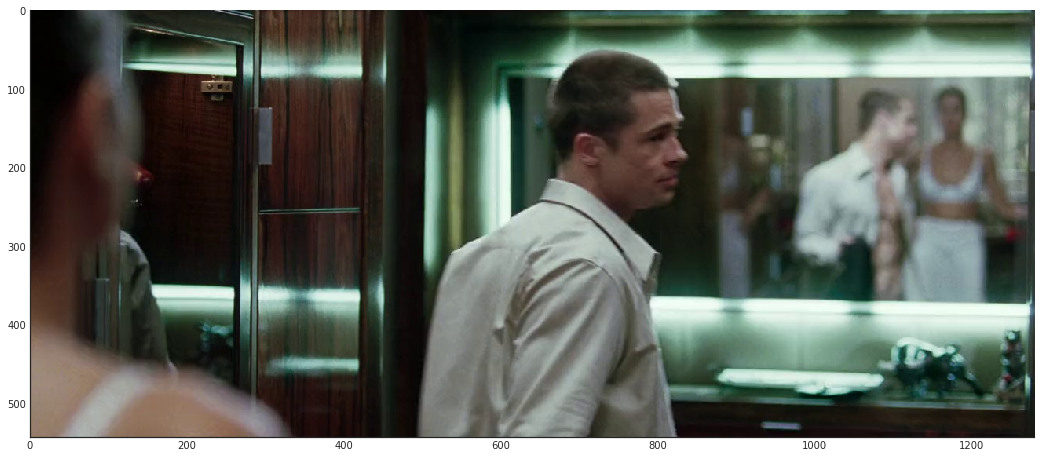

In [18]:
# Load up an image and run it through the network
vid_id = list(shots_gt.get_allintervals().keys())[0]
frame = shots_gt.get_intervallist(vid_id).get_intervals()[0].start
img = cv2.cvtColor(load_frame(Video.objects.get(id=vid_id), frame, []), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [19]:
#img_tensor = transforms.ToTensor()(img)

In [20]:
#tenlayer_resnet(img_tensor.unsqueeze(0))

tensor([[-0.5427,  0.2356,  0.1330,  0.3996, -0.2516,  0.0507, -0.0100,  0.2005,
          0.7879,  0.3185,  0.3106,  0.2262, -0.6144,  0.1037, -0.5680, -0.3739,
          0.1790, -0.1454,  0.1319, -0.0134, -0.2616, -0.5219, -0.0833, -0.1862,
         -0.0444, -0.5448,  0.3734,  0.6123, -0.1656,  0.1492,  0.0762,  0.2157,
         -0.2348,  0.2697,  0.2650, -0.4132,  0.0008, -0.4583, -0.0056,  0.0002,
         -0.1178, -0.0501, -0.3071,  0.7342,  0.1349,  0.2815,  0.0921, -0.2531,
         -0.1230,  0.4036,  0.2406, -0.2602, -0.2777, -0.4616,  0.0312,  0.2307,
         -0.4695,  0.2644,  0.5937,  0.4584,  0.2585,  0.1209,  0.4345, -0.0495,
         -0.0713, -0.0722,  0.0732, -0.1891, -0.0522, -0.0578, -0.4660,  0.1736,
         -0.3410,  0.2542,  0.6356, -0.2938,  0.3567,  0.1490,  0.1607, -0.2401,
          0.1913,  0.3884, -0.0209, -0.6463, -0.2735, -0.0422,  0.5916,  0.0582,
          0.5367,  0.0418,  0.1825, -0.2234,  0.0921, -0.1391,  0.2989, -0.0553,
          0.3659,  0.4385, -

In [24]:
#imgs = [
#    cv2.cvtColor(load_frame(Video.objects.get(id=vid_id), f, []), cv2.COLOR_BGR2RGB)
#    for f in range(frame-1, frame+2)
#]

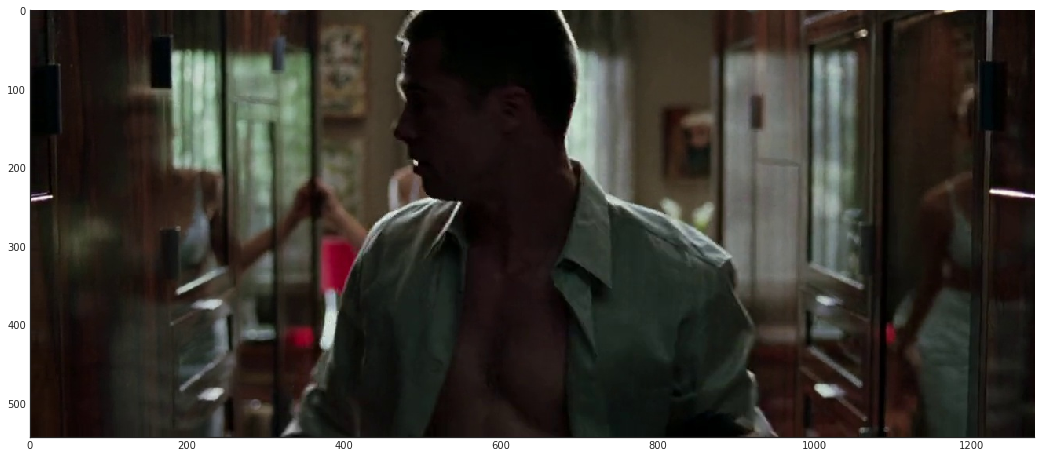

In [25]:
plt.imshow(imgs[0])

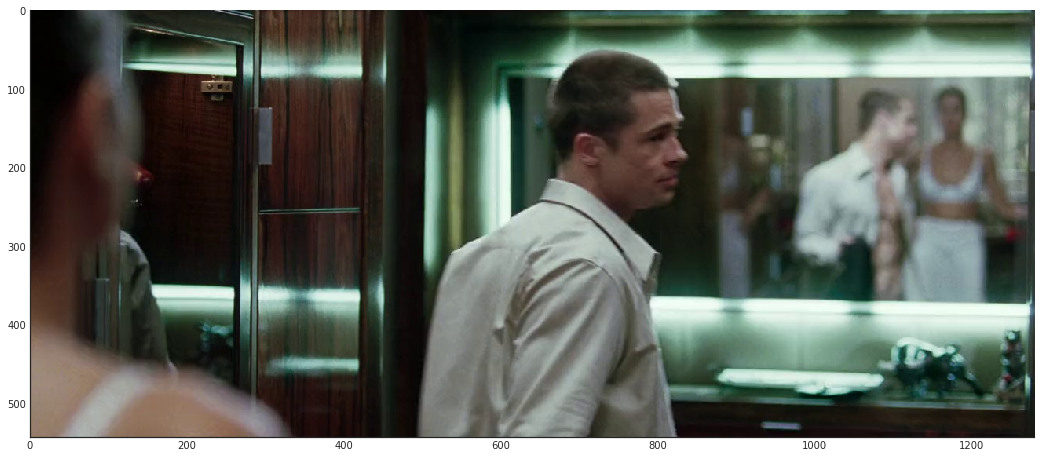

In [26]:
plt.imshow(imgs[1])

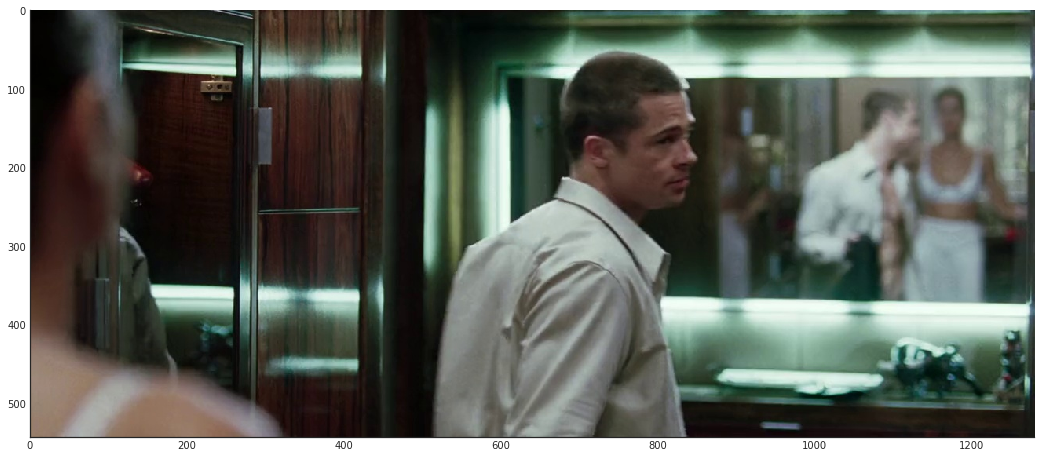

In [27]:
plt.imshow(imgs[2])

In [28]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [29]:
img_tensors = [
    transform(npimg).unsqueeze(0)
    for npimg in imgs
]

In [30]:
img_tensors[0].size()

torch.Size([1, 3, 224, 527])

In [51]:
vnet(img_tensors[0], img_tensors[1], img_tensors[2])

torch.Size([1, 128])
torch.Size([3, 128])
torch.Size([1, 1, 3, 128])
torch.Size([1, 64, 3, 128])
torch.Size([1, 64, 3, 128])


tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)

In [69]:
class ShotDetectionDataset(Dataset):
    def __init__(self, shots, window_size=1, height=224):
        """Constrcutor for ShotDetectionDataset.
        
        Args:
            shots: VideoIntervalCollection of all the intervals to get frames from.
        """
        self.window_size = window_size
        frames = set()
        
        for video_id in shots.get_allintervals():
            for intrvl in shots.get_intervallist(video_id).get_intervals():
                for f in range(intrvl.start, intrvl.end + 1):
                    frames.add((video_id, f, 1 if f == intrvl.start else 0))
        self.frames = sorted(list(frames))
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        """
        Indexed by video ID, then frame number
        Returns self.window_size frames before the indexed frame to self.window_size
            frames after the indexed frame
        """
        video_id, frame_num, label = self.frames[idx]
        npimgs = [
            cv2.cvtColor(load_frame(Video.objects.get(id=video_id), f, []), cv2.COLOR_BGR2RGB)
            for f in range(frame_num-self.window_size, frame_num+self.window_size + 1)
        ]
        img_tensors = [
            self.transform(npimg)
            for npimg in imgs
        ]
        
        return img_tensors, label

In [70]:
dataset = ShotDetectionDataset(shots_gt)

In [34]:
len(dataset)

4774

In [58]:
for i in range(len(dataset)):
    sample = dataset[i]
    
    print(i, sample)
    
    if i == 3:
        break

0 [tensor([[[[-0.7569, -0.7569, -0.7569,  ..., -0.9137, -0.8980, -0.8824],
          [-0.7804, -0.7804, -0.7804,  ..., -0.9137, -0.8980, -0.8745],
          [-0.7882, -0.7961, -0.7961,  ..., -0.9216, -0.9059, -0.8824],
          ...,
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8275, -0.8275, -0.8353,  ..., -0.9529, -0.9608, -0.9608],
          ...,
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9765, -0.9686, -0.9608],
          [-0.8353, -0.8353

3 [tensor([[[[-0.7569, -0.7569, -0.7569,  ..., -0.9137, -0.8980, -0.8824],
          [-0.7804, -0.7804, -0.7804,  ..., -0.9137, -0.8980, -0.8745],
          [-0.7882, -0.7961, -0.7961,  ..., -0.9216, -0.9059, -0.8824],
          ...,
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9373, -0.9529, -0.9451]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8353, -0.8353, -0.8353,  ..., -0.9529, -0.9529, -0.9529],
          [-0.8275, -0.8275, -0.8353,  ..., -0.9529, -0.9608, -0.9608],
          ...,
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9451, -0.9608, -0.9529]],

         [[-0.8353, -0.8353, -0.8353,  ..., -0.9765, -0.9686, -0.9608],
          [-0.8353, -0.8353

In [73]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)

In [75]:
for i_batch, sample_batched in enumerate(dataloader):
    sample, label = sample_batched
    print(i_batch, len(sample))
    print(sample[0].size())
    print(label)
    if i_batch == 3:
        break

0 3
torch.Size([4, 3, 224, 527])
tensor([1, 0, 0, 0])
1 3
torch.Size([4, 3, 224, 527])
tensor([0, 0, 0, 0])
2 3
torch.Size([4, 3, 224, 527])
tensor([0, 0, 0, 0])
3 3
torch.Size([4, 3, 224, 527])
tensor([0, 0, 0, 0])


In [57]:
vnet(sample_batched[0], sample_batched[1], sample_batched[2])

torch.Size([4, 1, 128])
torch.Size([4, 3, 128])
torch.Size([4, 1, 3, 128])
torch.Size([4, 64, 3, 128])
torch.Size([4, 64, 3, 128])


tensor([[0.4878, 0.5122],
        [0.4878, 0.5122],
        [0.4878, 0.5122],
        [0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)

In [58]:
vnet.train()

VideoNet(
  (resnet1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.

In [62]:
outs = vnet(sample_batched[0], sample_batched[1], sample_batched[2])

torch.Size([4, 1, 128])
torch.Size([4, 3, 128])
torch.Size([4, 1, 3, 128])
torch.Size([4, 64, 3, 128])
torch.Size([4, 64, 3, 128])


In [63]:
torch.max(outs, 1)

(tensor([0.5122, 0.5122, 0.5122, 0.5122], grad_fn=<MaxBackward0>),
 tensor([1, 1, 1, 1]))

In [78]:
len(list(vnet.modules()))

138